# Laboratorio 8. Detección de Anomalías con Autoencoder, Isolation Forest y LOF


In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

## Carga de los datos

In [2]:
# Cargar dataset
covtype = fetch_covtype(as_frame=True)  # lo pedimos como DataFrame
X = covtype.data
y = covtype.target  # Cover_Type original (1–7)

# Revisar estructura
print(X.shape)
print(X.head())
print(y.value_counts())

(581012, 54)
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0      

## Escalar datos

In [3]:
# Separar numéricas y binarias
X_num = X.iloc[:, :10]     # primeras 10 columnas numéricas
X_bin = X.iloc[:, 10:]     # resto: binarias (0/1)

# Escalar numéricas
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

# Unir de nuevo
X_scaled = pd.concat([X_num_scaled, X_bin], axis=1)

## Etiquetar

In [4]:
y_binary = np.where(y == 2, 1, 0)  # 1 = normal, 0 = anómalo

# Revisar proporción
pd.Series(y_binary).value_counts(normalize=True)

0    0.512401
1    0.487599
Name: proportion, dtype: float64

## Autocodificador

### División train/val/test

In [5]:
from sklearn.model_selection import train_test_split

# Dividimos train+val vs test (incluyendo normales y anómalos en test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# De X_temp nos quedamos solo con los normales (para entrenar el AE)
X_temp_norm = X_temp[y_temp == 1]

# train y val (solo normales)
X_train, X_val = train_test_split(
    X_temp_norm, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape, " (con normales y anomalías)")

Train: (181312, 54)
Val: (45329, 54)
Test: (116203, 54)  (con normales y anomalías)


### Modelo

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, Input

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, f1_score

In [7]:
input_dim = X_train.shape[1]

# Definir el modelo
input_layer = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(32, activation="relu")(input_layer)
encoded = layers.Dense(16, activation="relu")(encoded)
bottleneck = layers.Dense(8, activation="relu")(encoded)

# Decoder (simétrico)
decoded = layers.Dense(16, activation="relu")(bottleneck)
decoded = layers.Dense(32, activation="relu")(decoded)
output_layer = layers.Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)

# Compilación con MSE
autoencoder.compile(optimizer="adam", loss="mse")

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Entrenamiento
history = autoencoder.fit(
    X_train,
    X_train,  # se entrena a reconstruir la entrada
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

Epoch 1/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1639 - val_loss: 0.1281
Epoch 2/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1220 - val_loss: 0.1181
Epoch 3/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1167 - val_loss: 0.1150
Epoch 4/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1140 - val_loss: 0.1123
Epoch 5/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1110 - val_loss: 0.1099
Epoch 6/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1070 - val_loss: 0.1030
Epoch 7/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1028 - val_loss: 0.1022
Epoch 8/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1021 - val_loss: 0.1017
Epoch 9/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1017 - val_loss: 0.1013
Epoch 10/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1014 - val_loss: 0.1010
Epoch 11/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1012 - val_loss: 0.1008
Epoch 12/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [8]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder con Batch Normalization y Dropout
encoded = layers.Dense(128, activation="relu")(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)

encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)

encoded = layers.Dense(32, activation="relu")(encoded)
encoded = layers.BatchNormalization()(encoded)

# Bottleneck más grande
bottleneck = layers.Dense(32, activation="relu")(encoded)

# Decoder simétrico
decoded = layers.Dense(32, activation="relu")(bottleneck)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(64, activation="relu")(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(128, activation="relu")(decoded)
decoded = layers.BatchNormalization()(decoded)

# Salida lineal para datos estandarizados (NO sigmoid)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

ae = Model(inputs=input_layer, outputs=output_layer)

# MSE es mejor que MAE para autoencoders
ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )
]

history2 = ae.fit(
    X_train, X_train,
    epochs=150,
    batch_size=128,  # Batch más pequeño
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0810 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 2/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0330 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 3/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0260 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 4/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0216 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 5/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0184 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 6/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0162 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 7/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0146 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 8/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0134 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 9/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0122 - val_loss: 0.0038 - learn

### Métricas AE1

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 778us/step
5666/5666 ━━━━━━━━━━━━━━━━━━━━ 5s 961us/step


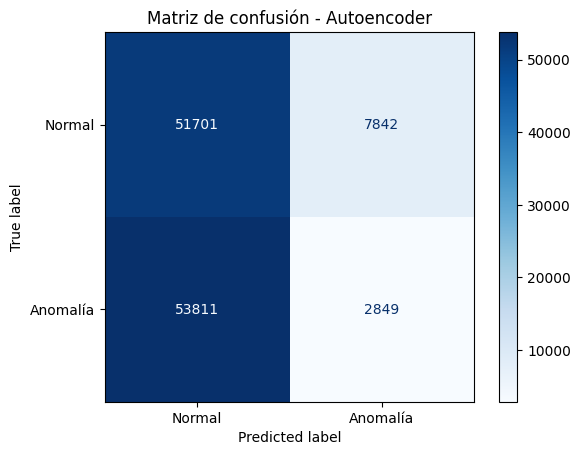

In [9]:
# Predicciones del autoencoder
X_test_pred = autoencoder.predict(X_test)

# Error de reconstrucción (MSE fila por fila)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calcular umbral (ej: percentil 95 del error en train)
train_pred = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - train_pred), axis=1)
threshold = np.percentile(train_errors, 95)

# Predicciones binarias
y_pred_binary = (reconstruction_errors > threshold).astype(int)  # 1 = anomalía

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomalía"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Autoencoder")
plt.show()

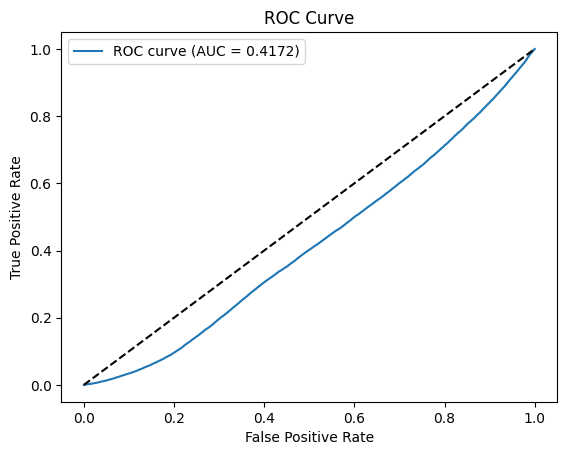

In [10]:
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = roc_auc_score(y_test, reconstruction_errors)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

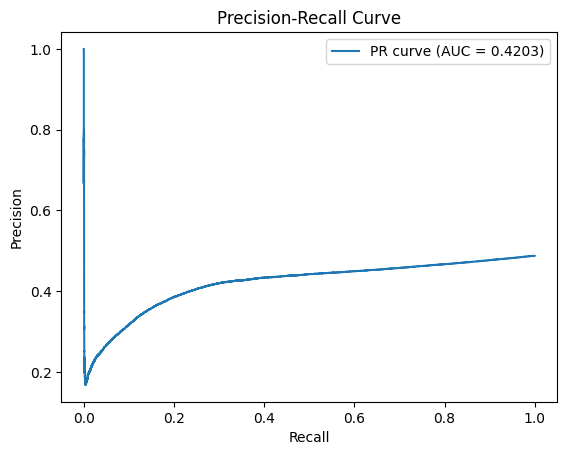

In [11]:
precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
pr_auc = average_precision_score(y_test, reconstruction_errors)

plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [12]:
f1 = f1_score(y_test, y_pred_binary)
print("F1@umbral:", f1)

F1@umbral: 0.08460156493593265


In [13]:
def precision_at_k(y_true, scores, k):
    # Ordenar por score (descendente)
    idx = np.argsort(scores)[::-1]
    top_k = idx[:k]
    return np.mean(y_true[top_k])

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test, reconstruction_errors, k):.4f}")

Precision@10: 0.7000
Precision@50: 0.6800
Precision@100: 0.3900


### Métricas AE2

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5666/5666 ━━━━━━━━━━━━━━━━━━━━ 6s 974us/step


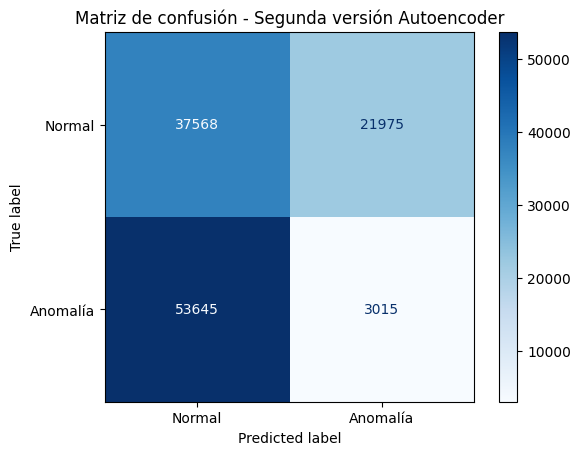

In [14]:
## Autoencoder 2
# Predicciones del autoencoder
X_test_pred2 = ae.predict(X_test)

# Error de reconstrucción (MSE fila por fila)
reconstruction_errors2 = np.mean(np.square(X_test - X_test_pred2), axis=1)

# Calcular umbral (ej: percentil 95 del error en train)
train_pred2 = ae.predict(X_train)
train_errors2 = np.mean(np.square(X_train - train_pred2), axis=1)
threshold2 = np.percentile(train_errors2, 95)

# Predicciones binarias
y_pred_binary2 = (reconstruction_errors2 > threshold2).astype(int)  # 1 = anomalía

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomalía"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Segunda versión Autoencoder")
plt.show()

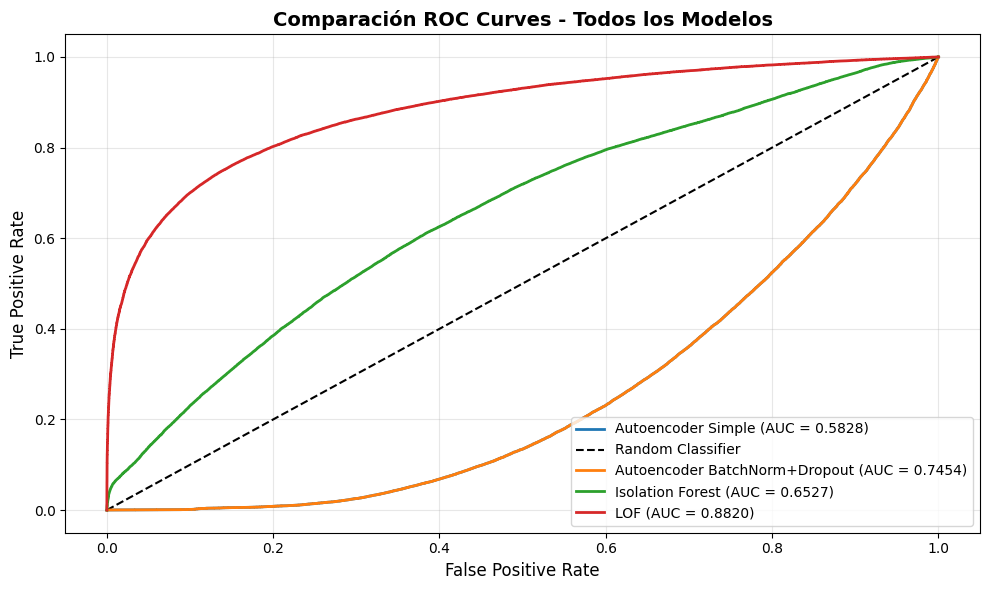

In [ ]:
# Gráfica ROC comparativa
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Autoencoder Simple (AUC = {roc_auc_ae1:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")

# Para AE2
fpr_ae2, tpr_ae2, _ = roc_curve(y_test, reconstruction_errors2)
plt.plot(fpr_ae2, tpr_ae2, label=f"Autoencoder BatchNorm+Dropout (AUC = {roc_auc_ae2:.4f})", linewidth=2)

# IF y LOF
plt.plot(fpr_if, tpr_if, label=f"Isolation Forest (AUC = {roc_auc_if:.4f})", linewidth=2)
plt.plot(fpr_lof, tpr_lof, label=f"LOF (AUC = {roc_auc_lof:.4f})", linewidth=2)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Comparación ROC Curves - Todos los Modelos", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



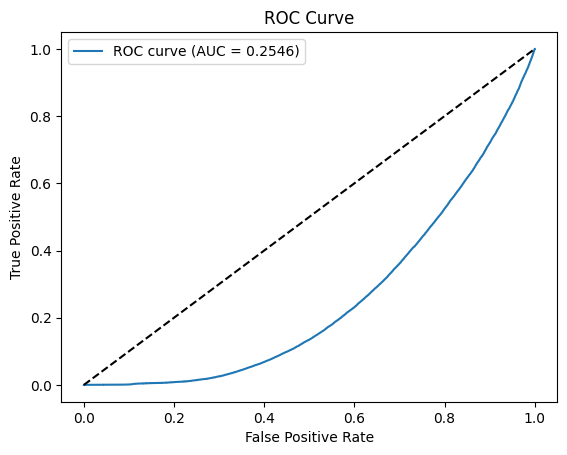

In [15]:
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors2)
roc_auc = roc_auc_score(y_test, reconstruction_errors2)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

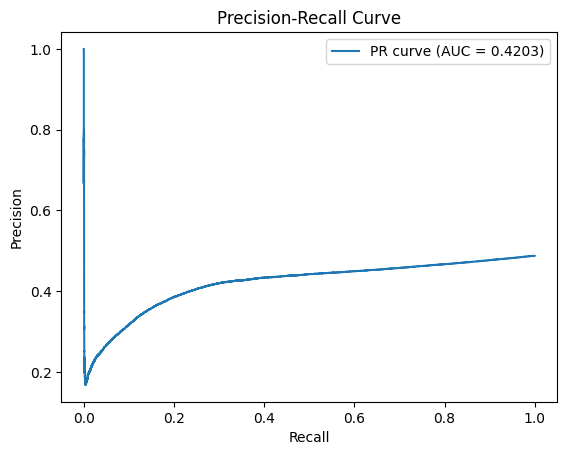

In [16]:
precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
pr_auc = average_precision_score(y_test, reconstruction_errors)

plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [17]:
f1 = f1_score(y_test, y_pred_binary2)
print("F1@umbral:", f1)

F1@umbral: 0.07385180649112064


In [18]:
def precision_at_k(y_true, scores, k):
    # Ordenar por score (descendente)
    idx = np.argsort(scores)[::-1]
    top_k = idx[:k]
    return np.mean(y_true[top_k])

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test, reconstruction_errors2, k):.4f}")

Precision@10: 1.0000
Precision@50: 0.2400
Precision@100: 0.1200


# Isolation Forest

In [31]:
y_test_inverted = 1 - y_test  # Ahora 1=anómalo, 0=normal

print(f"Anomalías en test (original y_test=0): {np.sum(y_test == 0)}")
print(f"Anomalías en test (invertido y_test_inverted=1): {np.sum(y_test_inverted == 1)}")


Anomalías en test (original y_test=0): 59543
Anomalías en test (invertido y_test_inverted=1): 59543


In [34]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    contamination=0.15,  
    random_state=42,
    n_estimators=100
)
iso_forest.fit(X_train)

y_pred_if = iso_forest.predict(X_test)
y_pred_if_binary = np.where(y_pred_if == -1, 1, 0)

# Scores: menor valor = más anómalo, multiplicar por -1
if_scores = iso_forest.decision_function(X_test)
if_anomaly_scores = -if_scores

print("Isolation Forest - Estadísticas:")
print(f"Anomalías predichas: {np.sum(y_pred_if_binary)}")
print(f"Anomalías verdaderas: {np.sum(y_test_inverted)}")
print(f"Scores - Min: {if_anomaly_scores.min():.4f}, Max: {if_anomaly_scores.max():.4f}")


Isolation Forest - Estadísticas:
Anomalías predichas: 27244
Anomalías verdaderas: 59543
Scores - Min: -0.0771, Max: 0.1173


## Evaluación Isolation Forest

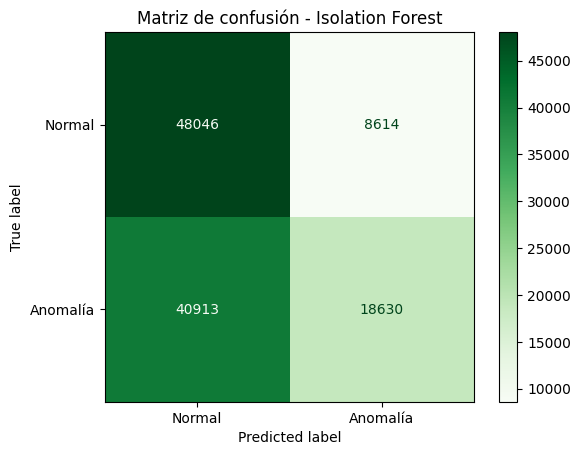

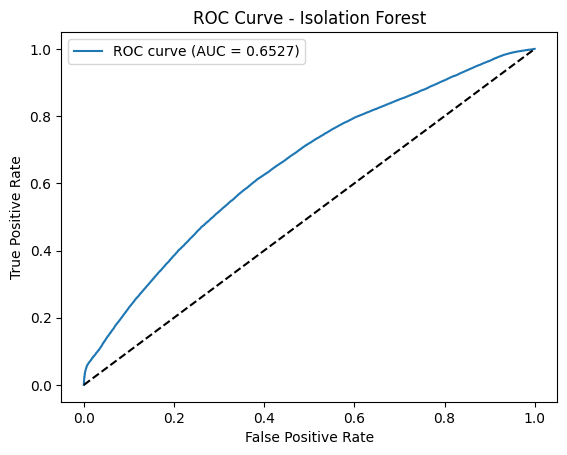

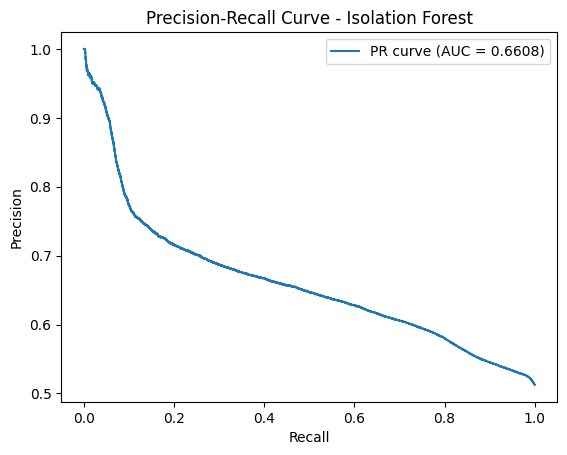

F1@umbral: 0.42932697293373434

Precision@k para Isolation Forest:
Precision@10: 1.0000
Precision@50: 1.0000
Precision@100: 1.0000


In [35]:
# Matriz de confusión (usar y_test_inverted)
cm_if = confusion_matrix(y_test_inverted, y_pred_if_binary)
disp_if = ConfusionMatrixDisplay(confusion_matrix=cm_if, display_labels=["Normal","Anomalía"])
disp_if.plot(cmap=plt.cm.Greens)
plt.title("Matriz de confusión - Isolation Forest")
plt.show()

# ROC-AUC (usar y_test_inverted)
fpr_if, tpr_if, _ = roc_curve(y_test_inverted, if_anomaly_scores)
roc_auc_if = roc_auc_score(y_test_inverted, if_anomaly_scores)

plt.plot(fpr_if, tpr_if, label=f"ROC curve (AUC = {roc_auc_if:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.legend()
plt.show()

# PR-AUC (usar y_test_inverted)
precision_if, recall_if, _ = precision_recall_curve(y_test_inverted, if_anomaly_scores)
pr_auc_if = average_precision_score(y_test_inverted, if_anomaly_scores)

plt.plot(recall_if, precision_if, label=f"PR curve (AUC = {pr_auc_if:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Isolation Forest")
plt.legend()
plt.show()

# F1-score (usar y_test_inverted)
f1_if = f1_score(y_test_inverted, y_pred_if_binary)
print("F1@umbral:", f1_if)

# Precision@k (usar y_test_inverted)
print("\nPrecision@k para Isolation Forest:")
for k in [10, 50, 100]:
    prec_k = precision_at_k(y_test_inverted, if_anomaly_scores, k)
    print(f"Precision@{k}: {prec_k:.4f}")

# Local Outlier Factor (LOF) 

In [36]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.15,
    novelty=True
)
lof.fit(X_train)

y_pred_lof = lof.predict(X_test)

# Convertir predicciones
y_pred_lof_binary = np.where(y_pred_lof == -1, 1, 0)

# Scores
lof_scores = lof.decision_function(X_test)
lof_anomaly_scores = -lof_scores

print("LOF - Estadísticas:")
print(f"Anomalías predichas: {np.sum(y_pred_lof_binary)}")
print(f"Anomalías verdaderas: {np.sum(y_test_inverted)}")

c:\Users\villa\Desktop\Clases_S8\4.Data Science\9.Lab_TODOS\Labs_Data_Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\villa\Desktop\Clases_S8\4.Data Science\9.Lab_TODOS\Labs_Data_Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF - Estadísticas:
Anomalías predichas: 54695
Anomalías verdaderas: 59543


 ## Evaluación Local Outlier Factor

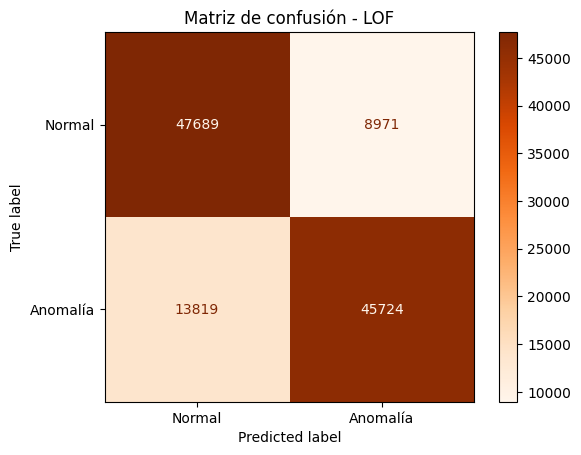

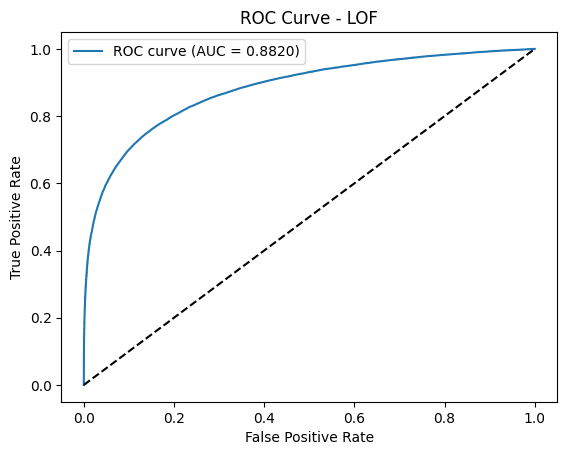

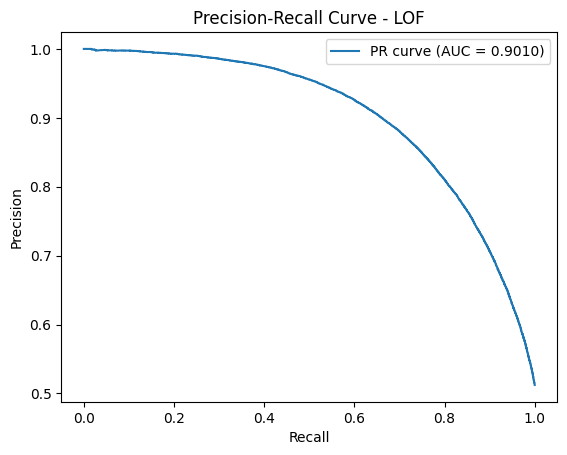

F1@umbral: 0.800504210507887

Precision@k para LOF:
Precision@10: 1.0000
Precision@50: 1.0000
Precision@100: 1.0000


In [37]:
# Matriz de confusión
cm_lof = confusion_matrix(y_test_inverted, y_pred_lof_binary)
disp_lof = ConfusionMatrixDisplay(confusion_matrix=cm_lof, display_labels=["Normal","Anomalía"])
disp_lof.plot(cmap=plt.cm.Oranges)
plt.title("Matriz de confusión - LOF")
plt.show()

# ROC-AUC
fpr_lof, tpr_lof, _ = roc_curve(y_test_inverted, lof_anomaly_scores)
roc_auc_lof = roc_auc_score(y_test_inverted, lof_anomaly_scores)

plt.plot(fpr_lof, tpr_lof, label=f"ROC curve (AUC = {roc_auc_lof:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LOF")
plt.legend()
plt.show()

# PR-AUC
precision_lof, recall_lof, _ = precision_recall_curve(y_test_inverted, lof_anomaly_scores)
pr_auc_lof = average_precision_score(y_test_inverted, lof_anomaly_scores)

plt.plot(recall_lof, precision_lof, label=f"PR curve (AUC = {pr_auc_lof:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LOF")
plt.legend()
plt.show()

# F1-score
f1_lof = f1_score(y_test_inverted, y_pred_lof_binary)
print("F1@umbral:", f1_lof)

# Precision@k
print("\nPrecision@k para LOF:")
for k in [10, 50, 100]:
    prec_k = precision_at_k(y_test_inverted, lof_anomaly_scores, k)
    print(f"Precision@{k}: {prec_k:.4f}")

# Comparación de Todos los Modelos


In [46]:
# Recalcular para Autoencoder 1
roc_auc_ae1 = roc_auc_score(y_test_inverted, reconstruction_errors)
pr_auc_ae1 = average_precision_score(y_test_inverted, reconstruction_errors)
f1_ae1 = f1_score(y_test_inverted, y_pred_binary)
prec_10_ae1 = precision_at_k(y_test_inverted, reconstruction_errors, 10)
prec_50_ae1 = precision_at_k(y_test_inverted, reconstruction_errors, 50)
prec_100_ae1 = precision_at_k(y_test_inverted, reconstruction_errors, 100)

# Recalcular para Autoencoder 2
roc_auc_ae2 = roc_auc_score(y_test_inverted, reconstruction_errors2)
pr_auc_ae2 = average_precision_score(y_test_inverted, reconstruction_errors2)
f1_ae2 = f1_score(y_test_inverted, y_pred_binary2)
prec_10_ae2 = precision_at_k(y_test_inverted, reconstruction_errors2, 10)
prec_50_ae2 = precision_at_k(y_test_inverted, reconstruction_errors2, 50)
prec_100_ae2 = precision_at_k(y_test_inverted, reconstruction_errors2, 100)

# Precision@k para IF y LOF
prec_10_if = precision_at_k(y_test_inverted, if_anomaly_scores, 10)
prec_50_if = precision_at_k(y_test_inverted, if_anomaly_scores, 50)
prec_100_if = precision_at_k(y_test_inverted, if_anomaly_scores, 100)

prec_10_lof = precision_at_k(y_test_inverted, lof_anomaly_scores, 10)
prec_50_lof = precision_at_k(y_test_inverted, lof_anomaly_scores, 50)
prec_100_lof = precision_at_k(y_test_inverted, lof_anomaly_scores, 100)

# Tabla comparativa
results_df = pd.DataFrame({
    'Modelo': ['Autoencoder Simple', 'Autoencoder (BatchNorm+Dropout)', 'Isolation Forest', 'LOF'],
    'ROC-AUC': [roc_auc_ae1, roc_auc_ae2, roc_auc_if, roc_auc_lof],
    'PR-AUC': [pr_auc_ae1, pr_auc_ae2, pr_auc_if, pr_auc_lof],
    'F1': [f1_ae1, f1_ae2, f1_if, f1_lof],
    'Precision@10': [prec_10_ae1, prec_10_ae2, prec_10_if, prec_10_lof],
    'Precision@50': [prec_50_ae1, prec_50_ae2, prec_50_if, prec_50_lof],
    'Precision@100': [prec_100_ae1, prec_100_ae2, prec_100_if, prec_100_lof]
})


print("TABLA COMPARATIVA")
print("="*130)
print(results_df.to_string(index=False))


TABLA COMPARATIVA
                         Modelo  ROC-AUC   PR-AUC       F1  Precision@10  Precision@50  Precision@100
             Autoencoder Simple 0.582772 0.604520 0.223311           0.3          0.32           0.61
Autoencoder (BatchNorm+Dropout) 0.745387 0.785711 0.519915           0.0          0.76           0.88
               Isolation Forest 0.652658 0.660829 0.429327           1.0          1.00           1.00
                            LOF 0.882044 0.901039 0.800504           1.0          1.00           1.00


## Gráfica ROC comparativa


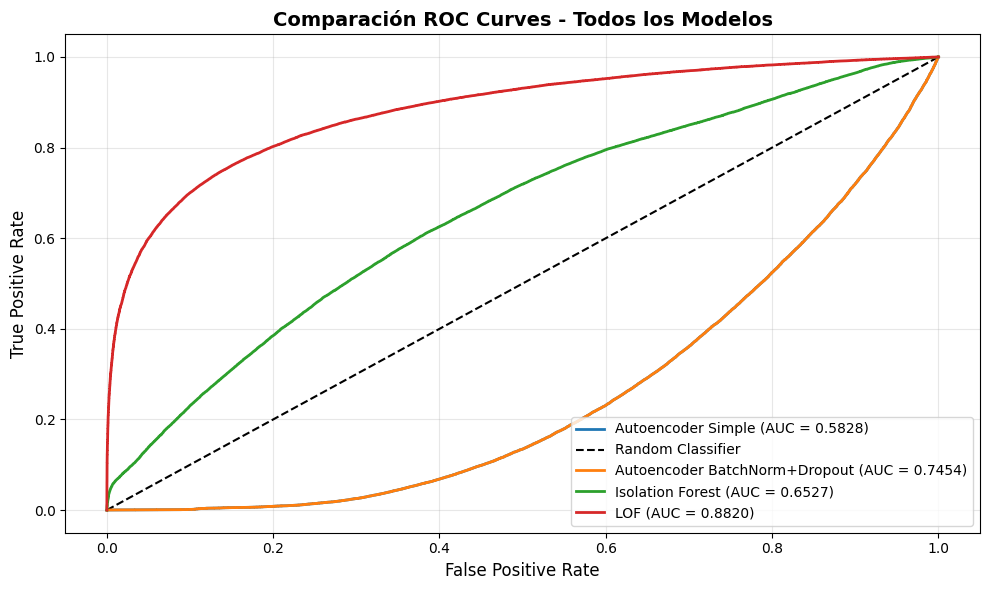

In [39]:
# Gráfica ROC comparativa
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Autoencoder Simple (AUC = {roc_auc_ae1:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")

# Para AE2
fpr_ae2, tpr_ae2, _ = roc_curve(y_test, reconstruction_errors2)
plt.plot(fpr_ae2, tpr_ae2, label=f"Autoencoder BatchNorm+Dropout (AUC = {roc_auc_ae2:.4f})", linewidth=2)

# IF y LOF
plt.plot(fpr_if, tpr_if, label=f"Isolation Forest (AUC = {roc_auc_if:.4f})", linewidth=2)
plt.plot(fpr_lof, tpr_lof, label=f"LOF (AUC = {roc_auc_lof:.4f})", linewidth=2)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Comparación ROC Curves - Todos los Modelos", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Gráfica Precision-Recall comparativa


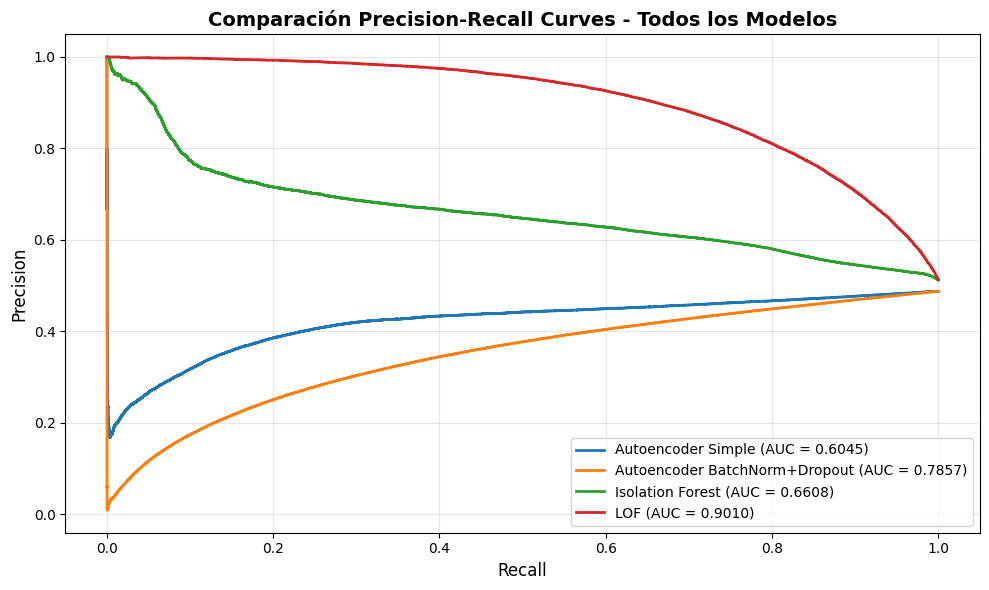

In [ ]:
# Gráfica Precision-Recall comparativa
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f"Autoencoder Simple (AUC = {pr_auc_ae1:.4f})", linewidth=2)

# Para AE2
precision_ae2, recall_ae2, _ = precision_recall_curve(y_test, reconstruction_errors2)
plt.plot(recall_ae2, precision_ae2, label=f"Autoencoder BatchNorm+Dropout (AUC = {pr_auc_ae2:.4f})", linewidth=2)

# IF y LOF
plt.plot(recall_if, precision_if, label=f"Isolation Forest (AUC = {pr_auc_if:.4f})", linewidth=2)
plt.plot(recall_lof, precision_lof, label=f"LOF (AUC = {pr_auc_lof:.4f})", linewidth=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Comparación Precision-Recall Curves - Todos los Modelos", fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Gráfica de barras comparativa de métricas


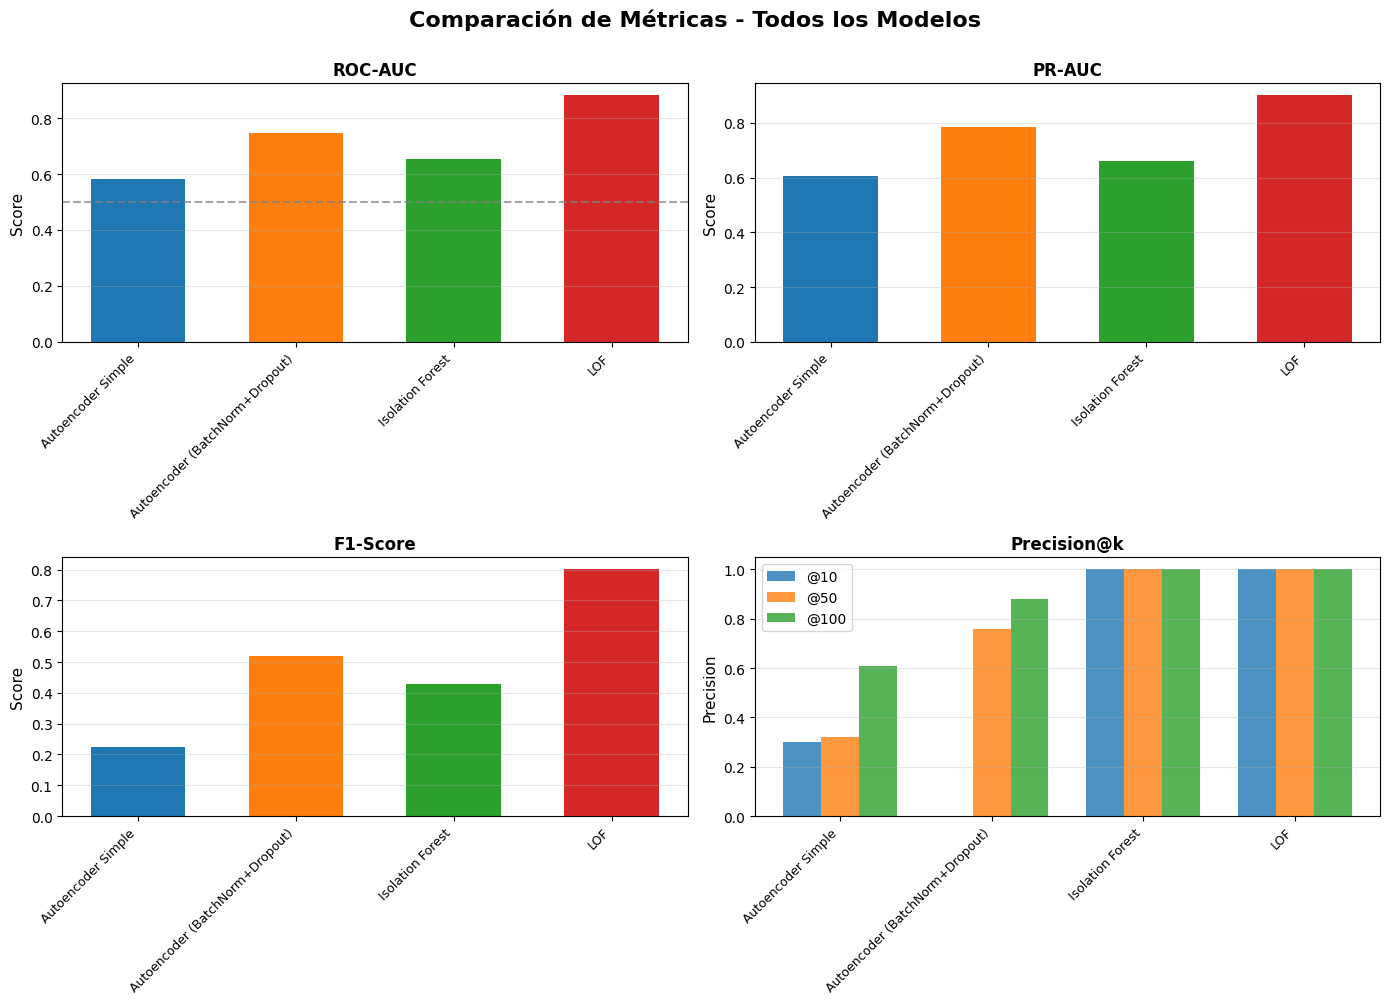

In [41]:
# Gráfica de barras comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

modelos = results_df['Modelo'].values
x = np.arange(len(modelos))
width = 0.6

# ROC-AUC
axes[0, 0].bar(x, results_df['ROC-AUC'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('ROC-AUC', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(modelos, rotation=45, ha='right', fontsize=9)
axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
axes[0, 0].grid(axis='y', alpha=0.3)

# PR-AUC
axes[0, 1].bar(x, results_df['PR-AUC'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('PR-AUC', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(modelos, rotation=45, ha='right', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# F1-Score
axes[1, 0].bar(x, results_df['F1'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('F1-Score', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(modelos, rotation=45, ha='right', fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Precision@k
x_prec = np.arange(len(modelos))
width_prec = 0.25
axes[1, 1].bar(x_prec - width_prec, results_df['Precision@10'], width_prec, label='@10', alpha=0.8)
axes[1, 1].bar(x_prec, results_df['Precision@50'], width_prec, label='@50', alpha=0.8)
axes[1, 1].bar(x_prec + width_prec, results_df['Precision@100'], width_prec, label='@100', alpha=0.8)
axes[1, 1].set_ylabel('Precision', fontsize=11)
axes[1, 1].set_title('Precision@k', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_prec)
axes[1, 1].set_xticklabels(modelos, rotation=45, ha='right', fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas - Todos los Modelos', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Resumen de Mejor Modelo

In [47]:
# Encontrar el mejor modelo según cada métrica
best_roc = results_df.loc[results_df['ROC-AUC'].idxmax()]
best_pr = results_df.loc[results_df['PR-AUC'].idxmax()]
best_f1 = results_df.loc[results_df['F1'].idxmax()]
best_prec10 = results_df.loc[results_df['Precision@10'].idxmax()]

print("RESUMEN: MEJORES MODELOS POR MÉTRICA")
print("="*80)
print(f"Mejor ROC-AUC:      {best_roc['Modelo']} ({best_roc['ROC-AUC']:.4f})")
print(f"Mejor PR-AUC:       {best_pr['Modelo']} ({best_pr['PR-AUC']:.4f})")
print(f"Mejor F1-Score:     {best_f1['Modelo']} ({best_f1['F1']:.4f})")
print(f"Mejor Precision@10: {best_prec10['Modelo']} ({best_prec10['Precision@10']:.4f})")


RESUMEN: MEJORES MODELOS POR MÉTRICA
Mejor ROC-AUC:      LOF (0.8820)
Mejor PR-AUC:       LOF (0.9010)
Mejor F1-Score:     LOF (0.8005)
Mejor Precision@10: Isolation Forest (1.0000)
